In [3]:
from classiq import *

## Quantum Random Walk

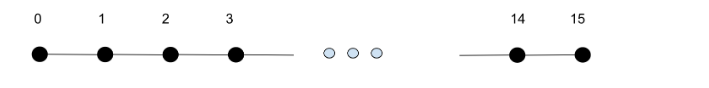

Quantum walks are quantum analogs of classical random walks. In contrast to the classical random walk, where the walker occupies definite states and the randomness arises due to stochastic transitions between states, in quantum walks randomness arises through (1) quantum superposition of states, (2) non-random, reversible unitary evolution and (3) collapse of the wave function due to state measurements.

In [5]:
"""
This cell defines the number of nodes required
"""
size=4 
nodes=16


In [7]:
"""
This cell prepares the |-> qubit state
"""
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

In [9]:
"""
The function diffuzer_oracle takes two parameters:
aux: An auxiliary quantum bit (qubit) represented as Output[QNum].
x: A quantum bit (qubit) represented as QNum.
x != 0: This checks if the qubit x is not in the state representing 0 (which in a quantum context usually means the ∣0⟩ state). 
Since x is a qubit, this comparison checks if x is in the ∣1⟩ state.
aux ^= (x != 0): The ^= operator here denotes a bitwise XOR operation. If the condition (x != 0) is true (meaning x is in the ∣1⟩ state),
the auxiliary qubit aux will be flipped. If the condition is false (meaning x is in the ∣0⟩ state), aux remains unchanged.
"""
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


In [11]:
"""
This function uses the within_apply tool to apply the diffuzer_oracle within the minus state preparation at the auxillary state
"""
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

In [25]:
"""
The W_iteration function outlines a single iteration of a quantum random walk, 
where the probability vector for the next state is set based on the current state,
and quantum operations are conditionally applied to prepare the state and perform diffusion.
The diffuzer_oracle function fits into this process as a critical component for spreading the probability amplitudes across the quantum states,
ensuring that the random walk progresses according to the defined probabilities.

If the current state is the first node (i == 0), the probability of moving to the next node (i + 1) is set to 1.
If the current state is the last node (i == nodes - 1), the probability of moving to the previous node (i - 1) is set to 1.
Otherwise, for any other node, the probabilities of moving to the next (i + 1) and previous (i - 1) nodes are both set to 0.5.
"""
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*nodes  #creates the list of 16 zeroes to initialize the probablity vector now next steps will be to modify
    if i==0:
     prob[i+1]=1
    elif i== nodes-1:
     prob[i-1]=1
    else:
     prob[i+1]=0.5
     prob[i-1]=0.5
    print(f'State={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


In [27]:
"""
The W_operator function orchestrates the quantum random walk by iterating over all the nodes in the graph and 
applying the W_iteration function to each node.
The function loops through each node in the graph, ensuring that the W_iteration function is applied to every node
For each node i, W_iteration prepares the quantum state according to the probability vector defined for that node and 
applies the diffusion process (via diffuzer_oracle or zero_diffuzer).
During each iteration, the quantum state is prepared based on the probabilities for transitioning to adjacent nodes.
The diffusion process spreads the probability amplitude across the quantum states, 
ensuring that the quantum walk progresses according to the defined probabilities.
"""
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(nodes):
      W_iteration(i,vertices,adjacent_vertices)

In [29]:
"""
This function checks if vertices and adjacent_vertices are adjacent, meaning the difference between them is either 1 or -1.
res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1)): 
This bitwise OR operation updates the res qubit to indicate whether the vertices are adjacent.
"""
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices-adjacent_vertices) ==1)  | ((vertices-adjacent_vertices) == -1))

"""
This function swaps the qubits in arrays x and y.
repeat(count= x.len, iteration= lambda i: SWAP(x[i], y[i])): Repeats the swap operation for each corresponding pair of qubits in the arrays.
"""
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
"""
res = QNum('res'): Initializes a new quantum number res.
edge_oracle(res, vertices, adjacent_vertices): Calls the edge_oracle function to determine if vertices and adjacent_vertices are adjacent and
stores the result in res.
control(ctrl= res == 1, operand= lambda: bitwise_swap(vertices, adjacent_vertices)): If res indicates that the vertices are adjacent (i.e., res == 1),
the bitwise_swap function is called to swap the vertices and adjacent_vertices
"""
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [31]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

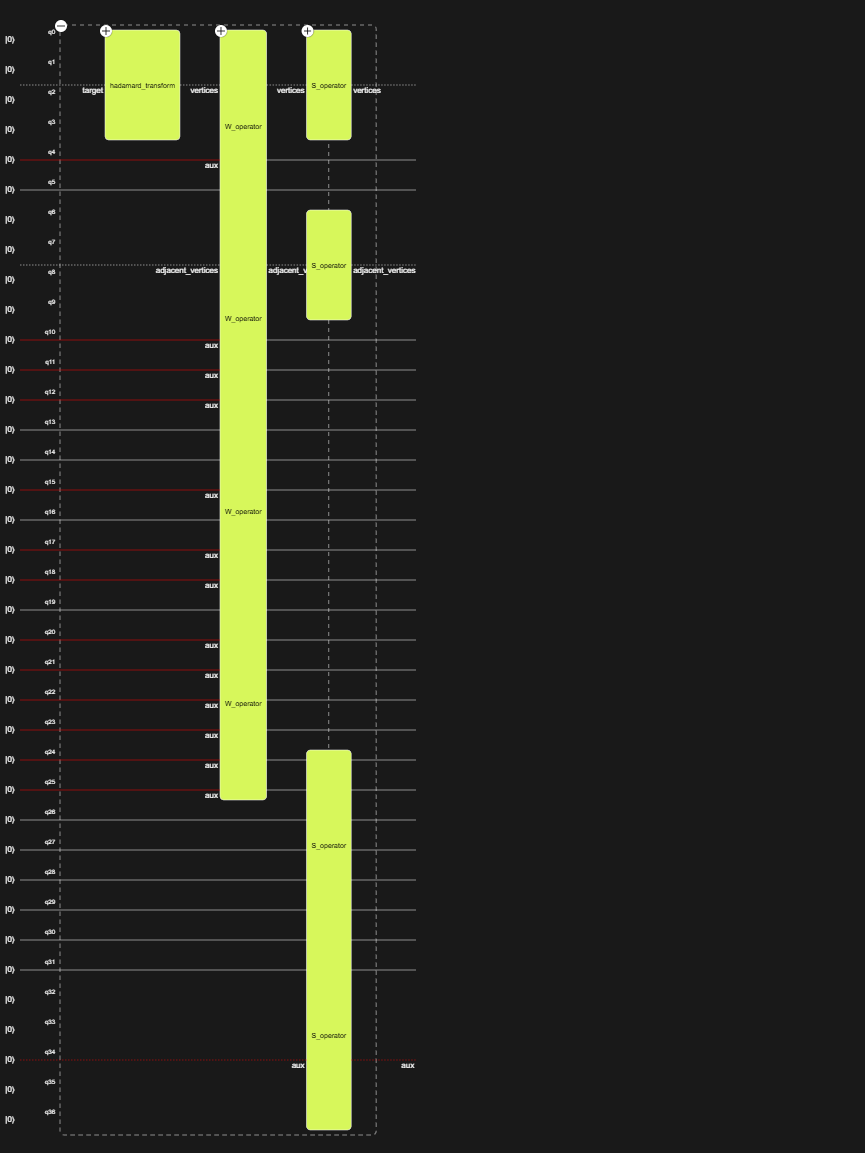